#### Monte Carlo integration

Previously from Bayesian optimal tracking

* Prediction step

$$\begin{align*}
p(x_n|y_{0:n-1})=\int p(x_n| x_{n-1})p(x_{n-1}|y_{0:n-1})dx_{n-1}\\
\end{align*}$$

* Update step

$$p(x_n|y_{0:n})=\frac{p(y_n|x_n)}{p(y_n|y_{0:n-1})}p(x_n|y_{0:n-1})$$

we see that the integral in prediction step is really causing the headache, Monte Carlo (MC) integration is a possible way out of this

For the integral

$$\mu =\int g(x)dx$$

the idea of MC integration is first to factor $g(x)$ as $g(x)=f(x)p(x)$, where $p(x)$ is some PDF

$$p(x)\geq 0, \int p(x) dx =1$$

(and $p(x)>0$ wherever $g(x)>0$)

Then, by definition, this integral becomes expected value

$$\mu =\mathbb{E}[f(x)]$$

Suppose we can draw a large number of `independent` samples from $p(x)$, then, we can use samples to approximate the integral as

$$\begin{align*}
\mu&=\int g(x)dx \\
&=\int f(x) p(x) dx\\
&=\mathbb{E}[f(x)]\\
& \approx \hat{\mu}_N\\
&=\frac{1}{N}\sum_{i=1}^N f(x^i)
\end{align*}$$

where $x^i$ denotes the ith sample from $p(x)$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import time

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

##### Mean estimation example

Suppose we have a random process

$$y=\cos(v), v\sim N(0, \sigma_v^2)$$

and we wish to estimate

$$\mathbb{E}[y]=\int \cos(v) p(v) dv$$

In [ ]:
# Numerical integration
n_bin = 10000
sigma_v = 1
v = np.linspace(-10, 10, n_bin)
w_bin = v[1] - v[0]

def g(v, sigma_v=sigma_v):
    return np.cos(v) * norm.pdf(v, 0, sigma_v)

e_y_num = np.sum(g(v) * w_bin)
print(f'Numerical integration: {e_y_num}')

Numerical integration: 0.6065306597124


In [ ]:
# MC integration
np.random.seed(42)

# To test different number of samples
n_sample = np.arange(1, 10000, 1)
mc_results = np.zeros_like(n_sample, dtype=float)

for idx, n in enumerate(n_sample):
    v_sample = np.random.normal(0, sigma_v, n)
    # Pointwise evaluation of cos(v), then take the mean
    mc_results[idx] = np.mean(np.cos(v_sample))

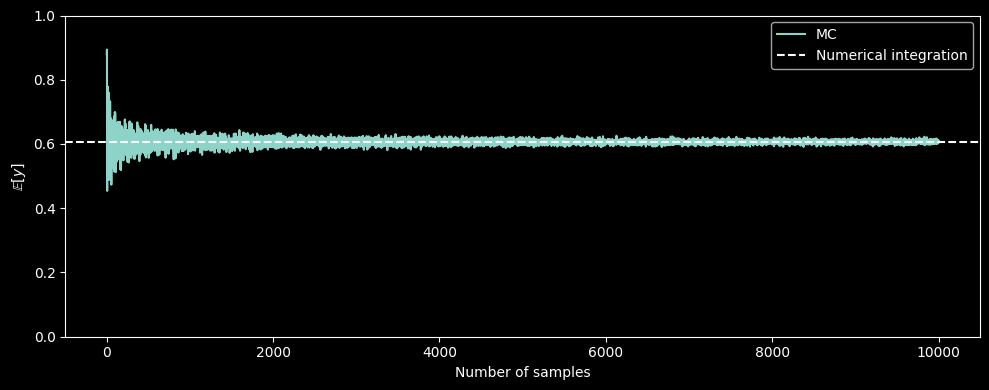

In [ ]:
# Plot
fig_0, ax_0 = plt.subplots(figsize=(10,4))

ax_0.plot(n_sample, mc_results, '-', label='MC')
ax_0.set_xlabel('Number of samples')
ax_0.set_ylabel('$\mathbb{E}[y]$')
ax_0.set_ylim(0, 1)
ax_0.axhline(e_y_num, ls='--', label='Numerical integration')
ax_0.legend()

plt.tight_layout()
plt.show()

#### Importance sampling

For the integral that we are interested in

$$\begin{align*}
p(x_n|y_{0:n-1})=\int p(x_n| x_{n-1})p(x_{n-1}|y_{0:n-1})dx_{n-1}\\
\end{align*}$$

while it is already in the form of

$$\int f(x)p(x) dx$$

`efficiently` drawing samples from $p(x_{n-1}|y_{0:n-1})$ is not simple, even though we may be able to `evaluate it pointwise`

Assume that we could only draw samples efficiently from `standard` random number generator $q(x)$, we can rewrite the integral

$$\begin{align*}
\mu &=\int f(x) p(x) dx \\
&=\int \left[f(x)\frac{p(x)}{q(x)}\right]q(x) dx
\end{align*}$$

and our estimator becomes

$$\begin{align*}
\hat{\mu}_N &=\frac{1}{N}\sum_{i=1}^Nf(x^i)\frac{p(x^i)}{q(x^i)} \\
&=\frac{1}{N}\sum_{i=1}^Nf(x^i) \tilde{w}(x^i)
\end{align*}$$

where $\tilde{w}(x^i)=p(x^i)/q(x^i)$ are `unnormalized` weights

This stands if $q(x)>0$ everywhere $p(x)>0$, $q(x)$ is known as `importance density`

##### Mean estimation example

We revisit our mean estimation example

$$\mathbb{E}[y]=\int \cos(v) p(v) dv$$

and assume this time, we only have access to uniform number generator

In [ ]:
np.random.seed(42)
n_sample = np.arange(1, 10000, 1)
mc_results = np.zeros_like(n_sample, dtype=float)

for idx, n in enumerate(n_sample):
    v_sample = np.random.uniform(-10, 10, n)
    # Pointwise evaluation of f(x)p(x)/q(x), then take the mean
    mc_results[idx] = np.mean(np.cos(v_sample) * norm.pdf(v_sample, 0, sigma_v)
                              / uniform.pdf(v_sample, -10, 20)) # [loc, loc + scale]

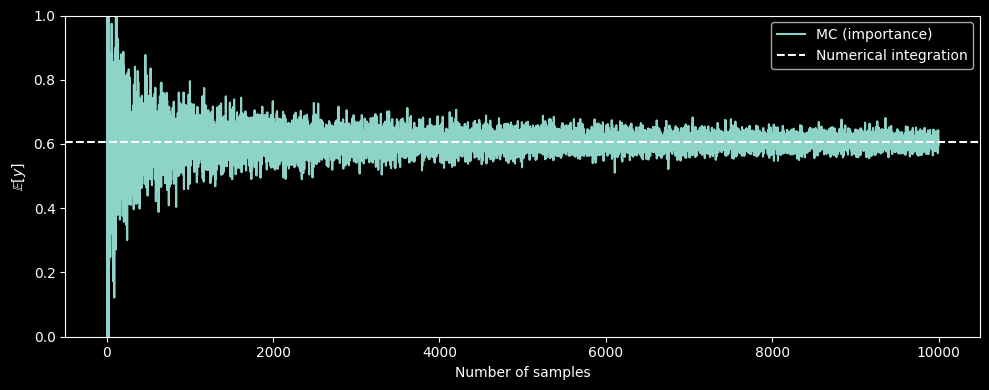

In [ ]:
fig_1, ax_1 = plt.subplots(figsize=(10,4))

ax_1.plot(n_sample, mc_results, '-', label='MC (importance)')
ax_1.set_xlabel('Number of samples')
ax_1.set_ylabel('$\mathbb{E}[y]$')
ax_1.set_ylim(0, 1)
ax_1.axhline(e_y_num, ls='--', label='Numerical integration')
ax_1.legend()

plt.tight_layout()
plt.show()

#### Weight normalization

In many cases, for

$$\int f(x)p(x) dx$$

we only have access to an `unnormalized` version of the density $\tilde{p}(x)=cp(x)$

This can happen for example in the update step

$$p(x_n|y_{0:n})=\frac{p(y_n|x_n)}{p(y_n|y_{0:n-1})}p(x_n|y_{0:n-1})$$

where we don't want to deal with the denominator $p(y_n|y_{0:n-1})$

This will lead to a biasd estimator of the integral

$$
\begin{align*}
\mu_b&=\int f(x)\tilde{p}(x)dx \\
&\approx \frac{1}{N}\sum_{i=1}^Nf(x^i)\frac{\tilde{p}(x^i)}{q(x^i)} \\
&\tilde{w}(x^i)=\tilde{p}(x^i)/q(x^i) \\
&= \frac{1}{N}\sum_{i=1}^Nf(x^i)\tilde{w}(x^i) \\
\end{align*}$$

Use the trick of setting $f(x)=1$, we can determine this bias

$$
\begin{align*}
c &= \int \tilde{p}(x)dx\\
&\approx \frac{1}{N}\sum_{i=1}^N \tilde{w}(x^i)
\end{align*}
$$

Then, we can get normalized estimator

$$
\begin{align*}
\hat{\mu}_N&=\frac{\frac{1}{N}\sum_{i=1}^Nf(x^i)\tilde{w}(x^i)}{\frac{1}{N}\sum_{j=1}^N\tilde{w}(x^j)} \\
&=\frac{\sum_{i=1}^Nf(x^i)\tilde{w}(x^i)}{\sum_{j=1}^N\tilde{w}(x^j)} \\
&=\sum_{i=1}^N f(x^i)\left(\frac{\tilde{w}(x^i)}{\sum_{j=1}^N \tilde{w}(x^j)}\right)\\
&=\sum_{i=1}^N f(x^i)w(x^i)
\end{align*}\\
$$

where

$$w(x^i)=\frac{\tilde{w}(x^i)}{\sum_{j=1}^N \tilde{w}(x^j)}$$

is `normalized weights`

and we don't have to worry about the scaling factor